> So far we have used only datasets that fit in memory, but Deep Learning systems are often trained on very large datasets that will not fit in RAM. Ingesting a large dataset and preprocessing it efficiently can be tricky to implement with other Deep Learning libraries, but TensorFlow makes it easy thanks to the Data API : you just create a dataset object, and tell it where to get the data and how to transform it. TensorFlow takes care of all the implementation details, such as multithreading, queuing, batching, and prefetching. Moreover, the Data API works seamlessly with tf.keras! Off the shelf, the Data API can read from text files (such as CSV files), binary files with fixed-size records, and binary files that use TensorFlow’s TFRecord format, which supports records of varying sizes. 
>
> TFRecord is a flexible and efficient binary format based on Protocol Buffers (an open source binary format). The Data API also has support for reading from SQL databases. Moreover, many open source extensions are available to read from all sorts of data sources, such as Google’s BigQuery service. Reading huge datasets efficiently is not the only difficulty: the data also needs to be preprocessed, usually normalized. Moreover, it is not always composed strictly of convenient numerical fields: there may be text features, categorical features, and so on. These need to be encoded, for example using one-hot encoding, bag-of-words encoding, or embeddings (as we will see, an embedding is a trainable dense vector that represents a category or token). One option to handle all this preprocessing is to write your own custom preprocessing layers. Another is to use the standard preprocessing layers provided by Keras. 
>
> In this chapter, we will cover the Data API, the TFRecord format, and how to create custom preprocessing layers and use the standard Keras ones. We will also take a quick look at a few related projects from TensorFlow’s ecosystem: 
- `TF Transform ( tf.Transform )` 
    - Makes it possible to write a single preprocessing function that can be run in batch mode on your full training set, before training (to speed it up), and then exported to a TF Function and incorporated into your trained model so that once it is deployed in production it can take care of preprocessing new instances on the fly. 
- `TF Datasets (TFDS)` 
    - Provides a convenient function to download many common datasets of all kinds, including large ones like ImageNet, as well as convenient dataset objects to manipulate them using the Data API. 

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "data"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# The Data API

## Datasets

The whole Data API revolves around the concept of a `dataset`: as you might suspect, this represents a sequence of data items. Usually you will use datasets that gradually read data from disk, but for simplicity let's create a dataset entirely in RAM using `tf.data.Dataset.from_tensor_slices()`:

In [2]:
X = tf.range(10) # any data tensor
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

The `from_tensor_slices()` function takes a tensor and creates a `tf.data.Dataset` whose elements are all the slices of $X$ (along the first dimension), so this dataset contains 10 items; tensors 0, 1, 2, ..., 9. 

In [3]:
X

<tf.Tensor: id=3, shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>

Equivalently:

In [4]:
dataset = tf.data.Dataset.range(10)
dataset

<RangeDataset shapes: (), types: tf.int64>

In [5]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


### Chaining Transformations
Once you have a dataset, you can apply all sorts of transformations to it by calling its transformation methods. Each method returns a nnew dataset, so you can chain transformations like this:

In [6]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int64)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure13_1.png?raw=true" alt="Figure 13-1" width=500>

As you can see, the `batch()` method had to output a final batch of size two instead of seven, but you can call it with `drop_remainder=True` if you want to drop this final batch so that all batches have the exact same size.

In [7]:
dataset = dataset.map(lambda x: x * 2)

In [8]:
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int64)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int64)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int64)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int64)
tf.Tensor([16 18], shape=(2,), dtype=int64)


In [9]:
##deprecated: 
# dataset = dataset.apply(tf.data.experimental.unbatch())
dataset = dataset.unbatch() # Items: 0,2,4,...

In [10]:
for item in dataset.take(5):
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)


In [11]:
dataset = dataset.filter(lambda x: x < 10)  # keep only items < 10
                                            # Items: 0 2 4 6 8 0 2 4 6...

In [12]:
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


### Shuffling the Data
As you know, Gradient Descent works best when the instances in the training set are independent and identically distrributed. A simple way to ensure this is to shuffle the instances using the `shuffle()` method. It will create a new dataset that will start by filling up a buffer with the first items of the source dataset. Then, whenever it is asked for an item, it will pull one out randomly from the buffer and replace it with a fresh one from the source dataset, until it has iterated entirely through the source dataset. 

> You must specify the buffer size, and it is important to make it large enough, or else shuffling will not be vey effective. 

In [13]:
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=3, seed=42, 
                          reshuffle_each_iteration=False).batch(7)
for item in dataset:
    print(item)

tf.Tensor([2 0 3 4 6 7 1], shape=(7,), dtype=int64)
tf.Tensor([9 8 0 2 1 5 5], shape=(7,), dtype=int64)
tf.Tensor([6 3 7 9 8 0 1], shape=(7,), dtype=int64)
tf.Tensor([2 4 5 3 4 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


In [14]:
for item in dataset:
    print(item)

tf.Tensor([2 0 3 4 6 7 1], shape=(7,), dtype=int64)
tf.Tensor([9 8 0 2 1 5 5], shape=(7,), dtype=int64)
tf.Tensor([6 3 7 9 8 0 1], shape=(7,), dtype=int64)
tf.Tensor([2 4 5 3 4 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


> If you call `repeat()` on a shuffled dataset, by default, it will generate a new order at every iteration. This is generally a good idea but if you prefer to reuse the same order at each iteration (e.g., for tests or debugging), you can set `reshuffle_set_iteration=False`.

**For a large dataset that does not fit in memory, this simple shuffling-buffer approach may not be sufficient**, since the buffer will be small compared to the dataset. One solution is to shuffle the source data itself (for example, on Linux you can shuffle text files using the shuf command). This will definitely improve shuffling a lot! Even if the source data is shuffled, you will usually want to shuffle it some more, or else the same order will be repeated at each epoch, and the model may end up being biased (e.g., due to some spurious patterns present by chance in the source data’s order). To shuffle the instances some more, a common approach is to split the source data into multiple files, then read them in a random order during training. However, instances located in the same file will still end up close to each other. 

**To avoid this you can pick multiple files randomly and read them simultaneously, interleaving their records. Then on top of that you can add a shuffling buffer using the `shuffle()` method. If all this sounds like a lot of work, don’t worry: the `Data API` makes all this possible in just a few lines of code. Let’s see how to do this.**


## Interleaving lines from multiple files

> ### begin{side}: Split the California dataset to multiple CSV files

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [15]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

In [16]:
X_mean, X_std

(array([ 3.89175860e+00,  2.86245478e+01,  5.45593655e+00,  1.09963474e+00,
         1.42428122e+03,  2.95886657e+00,  3.56464315e+01, -1.19584363e+02]),
 array([1.90927329e+00, 1.26409177e+01, 2.55038070e+00, 4.65460128e-01,
        1.09576000e+03, 2.36138048e+00, 2.13456672e+00, 2.00093304e+00]))

In [17]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

```python
> np.array_split(np.arange(20), 4)
[array([0, 1, 2, 3, 4]),
 array([5, 6, 7, 8, 9]),
 array([10, 11, 12, 13, 14]),
 array([15, 16, 17, 18, 19])]
```

In [18]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

# split into 20, 10, & 10 respectively
train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

Okay, now let's take a peek at the first few lines of one of these CSV files:

In [19]:
import pandas as pd

pd.read_csv(train_filepaths[10]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,2.3000,25.0,5.828179,0.958763,909.0,3.123711,36.25,-119.40,1.328
1,2.6848,26.0,4.594268,1.095023,888.0,1.339367,33.61,-117.71,0.741
2,5.5137,15.0,4.904437,1.010239,1382.0,2.358362,33.63,-117.73,1.618
3,4.4539,28.0,4.889417,1.023781,3211.0,3.818074,33.83,-118.26,1.922
4,1.8214,10.0,5.838983,1.271186,845.0,2.387006,36.76,-119.85,0.801


Or in text mode:

In [20]:
with open(train_filepaths[10]) as f:
    for i in range(5):
        print(f.readline(), end="") # end="" otherwise lines are sparse

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
2.3,25.0,5.828178694158075,0.9587628865979382,909.0,3.1237113402061856,36.25,-119.4,1.328
2.6848,26.0,4.5942684766214175,1.0950226244343892,888.0,1.339366515837104,33.61,-117.71,0.741
5.5137,15.0,4.90443686006826,1.0102389078498293,1382.0,2.358361774744027,33.63,-117.73,1.618
4.4539,28.0,4.889417360285375,1.0237812128418549,3211.0,3.8180737217598097,33.83,-118.26,1.922


In [21]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

> ### end{side}

## Building an Input Pipeline
>> Recall:
>>
>> **To avoid this you can pick multiple files randomly and read them simultaneously, interleaving their records. Then on top of that you can add a shuffling buffer using the `shuffle()` method. If all this sounds like a lot of work, don’t worry: the `Data API` makes all this possible in just a few lines of code. Let’s see how to do this.**



In [22]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [23]:
filepath_dataset

<DatasetV1Adapter shapes: (), types: tf.string>

By default, the `list_files()` function returns a dataset that shuffles the file paths. In general this is a good thing, but you can set `shuffle=False` if you do not want that, for some reason.

In [24]:
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_15.csv', shape=(), dtype=string)
tf.Ten

You can call the `interleave()` method to read from five files at a time and interleave their lines (skipping the first line of each file, which is the header row, using the `skip()` method):

In [25]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1), # skip the header row
    cycle_length=n_readers)

The `interleave()` method will create a dataset that will pull five file paths from the `filepath_dataset`, and for each one it will call the function you gave it ( a lambda in this example) to create a new dataset (in this case a `TextLineDataset`). When we iterate over the interleave dataset, it will cycle through these five `TestLineDatasets`, reading one line at a time from each until all datasets are out of items. Then it will get the next five file paths from the `filepath_dataset` and interleave them the same way, and so on until it runs out of file paths.

> For interleaving to work best, it is preferable to have files of identical length; otherwise the ends of the longest files will not be interleaved.

In [26]:
for line in dataset.take(5):
    print(line.numpy())

b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418'
b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0'
b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67'
b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205'
b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215'


> ### begin{side}

Notice that, these are just byte strings' we need to parse them and scale the data.

In [27]:
record_defaults=[0, np.nan, tf.constant(np.nan, dtype=tf.float64), "Hello", tf.constant([])]
parsed_fields = tf.io.decode_csv('1,2,3,4,5', record_defaults)
parsed_fields # field 4 is byte string

[<tf.Tensor: id=228, shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: id=229, shape=(), dtype=float32, numpy=2.0>,
 <tf.Tensor: id=230, shape=(), dtype=float64, numpy=3.0>,
 <tf.Tensor: id=231, shape=(), dtype=string, numpy=b'4'>,
 <tf.Tensor: id=232, shape=(), dtype=float32, numpy=5.0>]

Notice that all missing fields are replaced with their default value, when provided:

In [28]:
parsed_fields = tf.io.decode_csv(',,,,5', record_defaults)
parsed_fields

[<tf.Tensor: id=237, shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: id=238, shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: id=239, shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: id=240, shape=(), dtype=string, numpy=b'Hello'>,
 <tf.Tensor: id=241, shape=(), dtype=float32, numpy=5.0>]

The 5th field is compulsory (since we provided tf.constant([]) as the "default value"), so we get an exception if we do not provide it:

In [29]:
try:
    parsed_fields = tf.io.decode_csv(',,,,', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Field 4 is required but missing in record 0! [Op:DecodeCSV]


The number of fields should match exactly the number of fields in the `record_defaults`:

In [30]:
try:
    parsed_fields = tf.io.decode_csv('1,2,3,4,5,6,7', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Expect 5 fields but have 7 in record 0 [Op:DecodeCSV]


> ### end{side}

### Preprocessing the Data

In [31]:
n_inputs = 8 # X_train.shape[-1]

@tf.function
def preprocess(line):
    # defaults for X and y
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

In [32]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: id=280, shape=(8,), dtype=float32, numpy=
 array([ 0.16579157,  1.216324  , -0.05204565, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: id=281, shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

### Putting Everything Together
To make the code reusable, let's put together everything we have discussed so far into a small helper function: it will create and return a dataset that will efficiently load California housing data from multiple CSV files, process it, shuffle it, optionally repeat it, and batch it.

In [33]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    # combine
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    # interleave input lines
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    # shuffle
    dataset = dataset.shuffle(shuffle_buffer_size)
    # preprocess
    # remember, preprocess returns (X, y)
    ## standardize X
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    # split into batches
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure13_2.png?raw=true" alt="Figure 13-2" width=600>

#### Prefetching
By calling `prefetch(1)` at the end, we are creating a dataset that will do its best to always be one batch ahead. In other words, while our training algorithm is working on one batch, the dataset will already be working in parallel on getting the next batch ready. This can improve performance dramatically. If we also ensure that loading and preprocessing are multithreaded (by setting `num_parallel_calls` when calling `interleave()` and `map()`), we can exploit multiple cores on the CPU and hopefully make preparing one batch of data shorter than running a training step on the GPU: this way the GPU will be almost 100% utilized (except for the data transfer time from the CPU to the GPU), and training will run much faster.

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure13_3.png?raw=true" alt="Figure 13-3" width=600>

In [34]:
train_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in train_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[ 0.6665056  -1.4733541  -0.1490838  -0.03526644  1.959114   -0.22147495
   0.8636744  -1.1672716 ]
 [-1.0831131   1.3745404  -1.2141006  -0.03189679  5.4927344   0.05702152
  -0.73852515  0.641882  ]
 [-1.3424264   1.1372159  -0.55647117 -0.01984986 -0.01120797  0.43611524
  -0.7666345   0.66687185]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.931]
 [2.375]
 [1.072]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-0.8651243   0.10880951 -0.59822595 -0.08767922  0.15397418 -0.33017126
  -1.4084505   1.2565969 ]
 [ 0.05669242  0.10880951 -0.693401   -0.48260796 -0.93476784  0.25940838
  -0.64014494  0.21208216]
 [-0.02600925  0.02970133 -0.3056272  -0.20141873  0.33193284  0.23165078
   0.8496188  -1.1572781 ]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.295]
 [2.192]
 [2.207]], shape=(3, 1), dtype=float32)



## Using the Dataset With tf.keras

In [35]:
train_set = csv_reader_dataset(train_filepaths, repeat=None, 
                               n_read_threads=5, n_parse_threads=6)
valid_set = csv_reader_dataset(valid_filepaths,
                               n_read_threads=5, n_parse_threads=6)
test_set = csv_reader_dataset(test_filepaths,
                              n_read_threads=5, n_parse_threads=6)

In [36]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

In [37]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [38]:
batch_size = 32
model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10,
          validation_data=valid_set)

Train for 362 steps
Epoch 1/10
362/362 [==============================] - 1s 3ms/step - loss: 1.8642 - val_loss: 1.4698
Epoch 2/10
362/121 [=========================================================================================] - 1s 2ms/step - loss: 0.8599 - val_loss: 0.6321
Epoch 3/10
362/121 [=========================================================================================] - 1s 1ms/step - loss: 0.5672 - val_loss: 0.6055
Epoch 4/10
362/121 [=========================================================================================] - 1s 2ms/step - loss: 0.6884 - val_loss: 0.5496
Epoch 5/10
362/121 [=========================================================================================] - 1s 1ms/step - loss: 0.4422 - val_loss: 0.5235
Epoch 6/10
362/121 [=========================================================================================] - 1s 2ms/step - loss: 0.4613 - val_loss: 0.5197
Epoch 7/10
362/121 [=================================================================

In [39]:
model.evaluate(test_set, steps=len(X_test) // batch_size)

161/161 [==============================] - 0s 1ms/step - loss: 0.4517


0.4516648559466652

In [40]:
test_set

<DatasetV1Adapter shapes: ((None, 8), (None, 1)), types: (tf.float32, tf.float32)>

In [41]:
# we could instead just pass test_set, Keras would ignore the labels
new_set = test_set.map(lambda X, y: X) 
X_new = X_test
model.predict(new_set, steps=len(X_new) // batch_size)

array([[1.9597416],
       [2.7858577],
       [1.8699638],
       ...,
       [1.0954186],
       [2.152811 ],
       [1.9831681]], dtype=float32)

Unlike the other sets, the new_set will usually __not contain labels__ (if it does, Keras will just ignore them). Note that in all these cases, you can still use `NumPy arrays` instead of datasets if you want (but of course they need to have been loaded and preprocessed first).

If you want to build your own **custom training loop**, you can just iterate over the training set, very naturally:

In [42]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

n_epochs = 5
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
total_steps = n_epochs * n_steps_per_epoch
global_step = 0

for X_batch, y_batch in train_set.take(total_steps):
    global_step += 1
    print("\rGlobal step {}/{}".format(global_step, total_steps), end="")
    
    with tf.GradientTape() as tape:
        y_pred = model(X_batch)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Global step 1810/1810

it is even possible to create a `tf.function` that performs the whole training loop!

In [43]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):

    # n_epoch is used at 'repeat'
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    
    n_steps_per_epoch = len(X_train) // batch_size
    total_steps = n_epochs * n_steps_per_epoch
    global_step = 0
    
    for X_batch, y_batch in train_set.take(total_steps):
        global_step += 1
        if tf.equal(global_step % 100, 0):
            tf.print("\rGlobal step", global_step, "/", total_steps)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

Global step 100 / 1810
Global step 200 / 1810
Global step 300 / 1810
Global step 400 / 1810
Global step 500 / 1810
Global step 600 / 1810
Global step 700 / 1810
Global step 800 / 1810
Global step 900 / 1810
Global step 1000 / 1810
Global step 1100 / 1810
Global step 1200 / 1810
Global step 1300 / 1810
Global step 1400 / 1810
Global step 1500 / 1810
Global step 1600 / 1810
Global step 1700 / 1810
Global step 1800 / 1810


Here is a short description of each method in the `Dataset` class:

In [44]:
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● batch()              Combines consecutive elements of this dataset into batches.
● cache()              Caches the elements in this dataset.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Creates a `Dataset` whose elements are generated by `generator`.
● from_tensor_slices() Creates a `Dataset` whose elements are slices of the given tensors.
● from_tensors()       Creates a `Dataset` with a single element, comprising the given tensors.
● interleave()         Maps `map_func` across this dataset, and interleaves the results.
● list_files()         A da

# The `TFRecord` binary format

You now know how to build powerful input pipelines using the Data API! However, so far we have used CSV files, which are common, simple, and convenient but not really efficient, and do not support large or complex data structures (such as images or audio) very well. So let’s see how to use TFRecords instead. 

> If you are happy with CSV files (or whatever other format you are using), you do not have to use TFRecords. As the saying goes, if it ain’t broke, don’t fix it! TFRecords are useful when the bottleneck during training is loading and parsing the data. 

The `TFRecord` format is TensorFlow’s preferred format for storing large amounts of data and reading it efficiently. It is a very simple binary format that just contains a sequence of binary records of varying sizes. You can __create one using a `tf.io.TFRecordWriter`__:

In [45]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

And you can __read it using a `tf.data.TFRecordDataset`__:

In [46]:
filepaths = ["my_data.tfrecord"]

dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


You can read **multiple TFRecord** files with just one `TFRecordDataset`. By default it will read them one at a time, but if you set `num_parallel_reads=3`, it will read 3 at a time in parallel and interleave their records. Alternatively, you could obtain the same result by using `list_files()` and `interleave(num_parallel_calls=3)` as we did earlier to read multiple CSV files:

In [47]:
filepaths = [f"my_test_{i}.tfrecord" for i in range(5)] # 5 TFRecords

for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))
            # total 15 tf records

# retrieve in 3 parallel threads
dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


### Compressed TFRecord Files
It can sometimes be useful to compress your TFRecord files, especially if they need to be loaded via a network connection. You can create a compressed TFRecord file by setting the `options` argument: 

In [48]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

When reading a compressed TFRecord file, you need to specify the compression type: 

In [49]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


### A Brief Intro to Protocol Buffers

For this section you need to [install protobuf](https://developers.google.com/protocol-buffers/docs/downloads). In general you will not have to do so when using TensorFlow, as it comes with functions to create and parse protocol buffers of type `tf.train.Example`, which are generally sufficient. However, in this section we will learn about protocol buffers by creating our own simple protobuf definition, so we need the protobuf compiler (`protoc`): we will use it to compile the protobuf definition to a Python module that we can then use in our code.

First let's write a simple protobuf definition:

In [50]:
%%writefile person.proto
syntax = "proto3";
message Person {
  string name = 1;
  int32 id = 2;
  repeated string email = 3;
}

Overwriting person.proto


And let's compile it (the `--descriptor_set_out` and `--include_imports` options are only required for the `tf.io.decode_proto()` example below):

In [51]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [52]:
!ls person*

person.desc   person.proto  person_pb2.py


In [53]:
from person_pb2 import Person

person = Person(name="Al", id=123, email=["a@b.com"])  # create a Person
print(person)  # display the Person

name: "Al"
id: 123
email: "a@b.com"



In [54]:
person.name  # read a field

'Al'

In [55]:
person.name = "Alice"  # modify a field

In [56]:
person.email[0]  # repeated fields can be accessed like arrays

'a@b.com'

In [57]:
person.email.append("c@d.com")  # add an email address

In [58]:
s = person.SerializeToString()  # serialize to a byte string
s

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [59]:
person2 = Person()  # create a new Person
person2.ParseFromString(s)  # parse the byte string (27 bytes)

27

In [60]:
person == person2  # now they are equal

True

In [61]:
person2

name: "Alice"
id: 123
email: "a@b.com"
email: "c@d.com"

#### Custom protobuf

In rare cases, you may want to parse a custom protobuf (like the one we just created) in TensorFlow. For this you can use the `tf.io.decode_proto()` function:

In [62]:
person_tf = tf.io.decode_proto(
    bytes=s,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="person.desc")

person_tf.values

[<tf.Tensor: id=343559, shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: id=343560, shape=(1,), dtype=int32, numpy=array([123], dtype=int32)>,
 <tf.Tensor: id=343561, shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

For more details, see the [`tf.io.decode_proto()`](https://www.tensorflow.org/api_docs/python/tf/io/decode_proto) documentation.

### TensorFlow Protobufs
The main protobuf typically used in a `TFRecord` file is the `Example protobuf`, which represents one instance in a dataset. It contains a list of named features, where each feature can either be a list of byte strings, a list of floats or a list of integers. Here is the protobuf definition:

```proto
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

In [63]:
from tensorflow.core.example.feature_pb2 import BytesList, FloatList, Int64List
from tensorflow.core.example.feature_pb2 import Feature, Features#, Example

# ## or this way:
from tensorflow import train
BytesList = train.BytesList
FloatList = train.FloatList
Int64List = train.Int64List

Feature = train.Feature
Features = train.Features
Example = train.Example

`note`: All proto messages can be serialized to a binary-string using the `.SerializeToString` method:

In [64]:
person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }))

with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

### Loading and Parsing Examples
To load the serialized `Example` protobufs, we will use a `tf.data.TFRecordDataset` once again, and we will parse each `Example` using `tf.io.parse_single_example()`. This is a TensorFlow operation so it can be included in a TF Function. It requires at least __two arguments__: a __string scalar tensor containing the serialized data__, and a __description of each feature__. The description is a dictionary that maps each feature name to either a `tf.io.FixedLenFeature` descriptor *indicating the feature’s shape*, type and default value, or a `tf.io.VarLenFeature` descriptor *indicating only the type* (if the length may vary, such as for the "emails" feature)



In [65]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}
## compare to the below
for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example,
                                                feature_description)

In [66]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fd0a1ed0cd0>,
 'id': <tf.Tensor: id=343589, shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: id=343590, shape=(), dtype=string, numpy=b'Alice'>}

Instead of parsing examples one by one using tf.io.parse_single_example(), you may want to parse them batch by batch using `tf.io.parse_example()`:

In [67]:
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(20)
for serialized_examples in dataset:
    parsed_examples = tf.io.parse_example(serialized_examples,
                                              feature_description)

In [68]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fd0a1ed0cd0>,
 'id': <tf.Tensor: id=343589, shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: id=343590, shape=(), dtype=string, numpy=b'Alice'>}

The fixed length features are parsed as regular tensors, but the variable length features are parsed as sparse tensors.

In [69]:
parsed_example["emails"].values[0]

<tf.Tensor: id=343630, shape=(), dtype=string, numpy=b'a@b.com'>

In [70]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: id=343632, shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [71]:
parsed_example["emails"].values

<tf.Tensor: id=343587, shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

### Putting Images in TFRecords
A `BytesList` can contain any binary data you want, including any serialized object. For example, you can use `tf.io.encode_jpeg()` to encode an **image** using the JPEG format, and put this binary data in a BytesList. Later, when your code reads the TFRecord, it will start by parsing the Example, then you will need to call `tf.io.decode_jpeg()` to parse the data and get the original image (or you can use `tf.io.decode_image()`, which can decode any BMP, GIF, JPEG or PNG image). You can also store any tensor you want in a BytesList by serializing the tensor using `tf.io.serialize_tensor()`, then putting the resulting byte string in a BytesList feature. Later, when you parse the TFRecord, you can parse this data using `tf.io.parse_tensor()`.

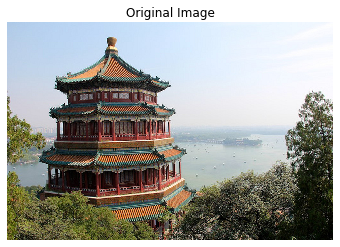

In [72]:
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [73]:
data = tf.io.encode_jpeg(img)

example_with_image = Example(
    features=Features(feature={
                "image": Feature(bytes_list=BytesList(value=[data.numpy()] ))}
                    )
                )
serialized_example = example_with_image.SerializeToString()
# then save to TFRecord

In [74]:
feature_description = { "image": tf.io.VarLenFeature(tf.string) }
example_with_image = tf.io.parse_single_example(serialized_example, feature_description)

decoded_img = tf.io.decode_jpeg(example_with_image["image"].values[0])

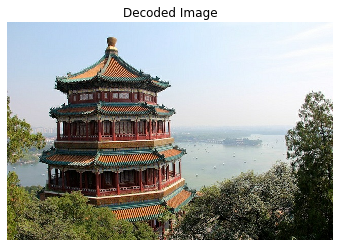

In [75]:
plt.imshow(decoded_img)
plt.title("Decoded Image")
plt.axis("off")
plt.show()

Or use `decode_image()` which supports BMP, GIF, JPEG and PNG formats:

### Putting Tensors and Sparse Tensors in TFRecords

Tensors can be serialized and parsed easily using `tf.io.serialize_tensor()` and `tf.io.parse_tensor()`:

In [76]:
t = tf.constant([[0., 1.], [2., 3.], [4., 5.]])
s = tf.io.serialize_tensor(t)
s

<tf.Tensor: id=343645, shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

In [77]:
tf.io.parse_tensor(s, out_type=tf.float32)

<tf.Tensor: id=343646, shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

In [78]:
serialized_sparse = tf.io.serialize_sparse(parsed_example["emails"])
serialized_sparse

<tf.Tensor: id=343647, shape=(3,), dtype=string, numpy=
array([b'\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x01"\x10\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x08\x07\x12\x04\x12\x02\x08\x02"\x10\x07\x07a@b.comc@d.com',
       b'\x08\t\x12\x04\x12\x02\x08\x01"\x08\x02\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)>

In [79]:
BytesList(value=serialized_sparse.numpy())

value: "\010\t\022\010\022\002\010\002\022\002\010\001\"\020\000\000\000\000\000\000\000\000\001\000\000\000\000\000\000\000"
value: "\010\007\022\004\022\002\010\002\"\020\007\007a@b.comc@d.com"
value: "\010\t\022\004\022\002\010\001\"\010\002\000\000\000\000\000\000\000"

## Handling Sequential Data Using `SequenceExample`

```proto
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
  Features context = 1;
  FeatureLists feature_lists = 2;
};
```

In [80]:
# from tensorflow.train import FeatureList, FeatureLists, SequenceExample
SequenceExample = train.SequenceExample
FeatureList = train.FeatureList
FeatureLists = train.FeatureLists
####


context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

# list of feature objects
content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]
            
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [81]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [82]:
serialized_sequence_example = sequence_example.SerializeToString()

In [83]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}

sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}

parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)

In [84]:
parsed_context

{'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fd0a2222750>,
 'author_id': <tf.Tensor: id=343665, shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: id=343666, shape=(3,), dtype=int64, numpy=array([1623,   12,   25])>}

In [85]:
parsed_context["title"].values

<tf.Tensor: id=343663, shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [86]:
parsed_feature_lists

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fd0a224ab10>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fd0a224ad10>}

In [87]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'], [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


# The Features API
The `Features API` can help you: it is a set of functions available in the `tf.feature_column` package, which let you define how each feature (or group of features) in your data should be preprocessed (therefore you can think of this API as the analog of `Scikit-Learn’s ColumnTransformer` class). We will start by looking at the different types of columns available, and then we will look at how to use them.

Let's use the variant of the California housing dataset that we used in Chapter 2, since it contains categorical features and missing values:

In [88]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [89]:
fetch_housing_data()

In [90]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [91]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [92]:
housing_median_age = tf.feature_column.numeric_column("housing_median_age")

In [93]:
housing_median_age

NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [94]:
X_mean[1], housing['housing_median_age'].mean()

(28.62454780361757, 28.639486434108527)

In [95]:
age_mean, age_std = X_mean[1], X_std[1]  # The median age is column in 1

housing_median_age = tf.feature_column.numeric_column(
    "housing_median_age", normalizer_fn=lambda x: (x - age_mean) / age_std)

In [96]:
median_income = tf.feature_column.numeric_column("median_income")
bucketized_income = tf.feature_column.bucketized_column(
    median_income, boundaries=[1.5, 3., 4.5, 6.])

In [97]:
bucketized_income

BucketizedColumn(source_column=NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.5, 3.0, 4.5, 6.0))

In [98]:
ocean_prox_vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
# "NEAR BAY" produces output 3
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list(
    "ocean_proximity", ocean_prox_vocab)

In [99]:
ocean_proximity

VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

In [100]:
# Just an example, it's not used later on
city_hash = tf.feature_column.categorical_column_with_hash_bucket(
    "city", hash_bucket_size=1000)
city_hash

HashedCategoricalColumn(key='city', hash_bucket_size=1000, dtype=tf.string)

> Combining features into a single feature, better known as `feature crosses`, enables a model to learn separate weights for each combination of features

In [101]:
bucketized_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=[-1., -0.5, 0., 0.5, 1.]) # age was scaled

age_and_ocean_proximity = tf.feature_column.crossed_column(
    [bucketized_age, ocean_proximity], hash_bucket_size=100)

In [102]:
latitude = tf.feature_column.numeric_column("latitude")

longitude = tf.feature_column.numeric_column("longitude")

bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=list(np.linspace(32., 42., 20 - 1)))

bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=list(np.linspace(-125., -114., 20 - 1)))

location = tf.feature_column.crossed_column(
    [bucketized_latitude, bucketized_longitude], hash_bucket_size=1000)

### Encoding Categorical Features Using One-Hot Vectors
No matter which option you choose to build a *categorical* feature (categorical columns, bucketized columns or crossed columns), it **must** be encoded before you can feed it to a neural network. There are two options to encode a categorical feature: `one-hot vectors` or `embeddings`. For the first option, simply use the `indicator_column()` function:

In [103]:
ocean_proximity_one_hot = tf.feature_column.indicator_column(ocean_proximity)

In [104]:
ocean_proximity_one_hot

IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0))

A one-hot vector encoding has the size of the vocabulary length, which is fine if there are just a few possible categories, but **if the vocabulary is large**, you will end up with too many inputs fed to your neural network: it will have too many weights to learn and it will probably not perform very well. In particular, this will typically be the case when you use hash buckets. In this case, you should probably encode them using `embeddings` instead.

In [105]:
ocean_proximity_embed = tf.feature_column.embedding_column(ocean_proximity,
                                                           dimension=2) # 5×2 matrix

In [106]:
ocean_proximity_embed

EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=2, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fd09115f650>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True)

> As a rule of thumb (but your mileage may vary!), if the number of categories is lower than 10, then one-hot encoding is generally the way to go. If the number of categories is greater than 50 (which is often the case when you use hash buckets), then embeddings are usually preferable. In between 10 and 50 categories, you may want to experiment with both options and see which one works best for your use case. Also, embeddings typically require more training data, unless you can reuse pretrained embeddings.



## Encoding Categorical Features Using Embeddings

An embedding is a trainable dense vector that represents a category. By default, embeddings are initialized randomly, so for example the "NEAR BAY" category could be represented initially by a random vector such as [0.131, 0.890], while the "NEAR OCEAN" category may be represented by another random vector such as [0.631, 0.791] (in this example, we are using 2D embeddings, but the number of dimensions is a hyperparameter you can tweak). Since these embeddings are trainable, they will gradually improve during training, and as they represent fairly similar categories, Gradient Descent will certainly end up pushing them closer together, while it will tend to move them away from the "INLAND" category’s embedding: __Embeddings Will Gradually Improve During Training__. Indeed, the better the representation, the easier it will be for the neural network to make accurate predictions, so training tends to make embeddings useful representations of the categories. This is called **representation learning** 

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure13_4.png?raw=true" alt="Figure 13-4" width=600>

## Word Embeddings
<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure13_5.png?raw=true" alt="Figure 13-5" width=600>

### Using Feature Columns for Parsing

In [107]:
median_house_value = tf.feature_column.numeric_column("median_house_value")

In [108]:
columns = [housing_median_age, median_house_value]
feature_descriptions = tf.feature_column.make_parse_example_spec(columns)
feature_descriptions

{'housing_median_age': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None),
 'median_house_value': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)}

In [109]:
with tf.io.TFRecordWriter("my_data_with_features.tfrecords") as f:
    for x, y in zip(X_train[:, 1:2], y_train):
        example = Example(features=Features(feature={
            "housing_median_age": Feature(float_list=FloatList(value=[x])),
            "median_house_value": Feature(float_list=FloatList(value=[y]))
        }))
        f.write(example.SerializeToString())

In [110]:
def parse_examples(serialized_examples):
    examples = tf.io.parse_example(serialized_examples, feature_descriptions)
    targets = examples.pop("median_house_value") # separate the targets
    return examples, targets

batch_size = 32
dataset = tf.data.TFRecordDataset(["my_data_with_features.tfrecords"])
dataset = dataset.repeat().shuffle(10000).batch(batch_size).map(parse_examples)

**Warning**: the `DenseFeatures` layer currently does not work with the Functional API, see [TF issue #27416](https://github.com/tensorflow/tensorflow/issues/27416). Hopefully this will be resolved before the final release of TF 2.0.

In [111]:
columns_without_target = columns[:-1]
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns=columns_without_target),
    keras.layers.Dense(1)
])
model.compile(loss="mse",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
model.fit(dataset, steps_per_epoch=len(X_train) // batch_size, epochs=5)

Train for 362 steps
Epoch 1/5
362/362 [==============================] - 1s 2ms/step - loss: 4.0222 - accuracy: 0.0015
Epoch 2/5
362/362 [==============================] - 0s 796us/step - loss: 1.9543 - accuracy: 0.0025
Epoch 3/5
362/362 [==============================] - 0s 860us/step - loss: 1.4758 - accuracy: 0.0027
Epoch 4/5
362/362 [==============================] - 0s 898us/step - loss: 1.3739 - accuracy: 0.0032
Epoch 5/5
362/362 [==============================] - 0s 812us/step - loss: 1.3353 - accuracy: 0.0030


In [112]:
len(X_train) // batch_size

362

In [113]:
some_columns = [ocean_proximity_embed, bucketized_income]
dense_features = keras.layers.DenseFeatures(some_columns)

In [114]:
dense_features.get_config()

{'name': 'dense_features_1',
 'trainable': True,
 'dtype': 'float32',
 'feature_columns': [{'class_name': 'BucketizedColumn',
   'config': {'source_column': {'class_name': 'NumericColumn',
     'config': {'key': 'median_income',
      'shape': (1,),
      'default_value': None,
      'dtype': 'float32',
      'normalizer_fn': None}},
    'boundaries': (1.5, 3.0, 4.5, 6.0)}},
  {'class_name': 'EmbeddingColumn',
   'config': {'categorical_column': {'class_name': 'VocabularyListCategoricalColumn',
     'config': {'key': 'ocean_proximity',
      'vocabulary_list': ('<1H OCEAN',
       'INLAND',
       'ISLAND',
       'NEAR BAY',
       'NEAR OCEAN'),
      'dtype': 'string',
      'default_value': -1,
      'num_oov_buckets': 0}},
    'dimension': 2,
    'combiner': 'mean',
    'initializer': {'class_name': 'TruncatedNormal',
     'config': {'mean': 0.0,
      'stddev': 0.7071067811865475,
      'seed': None,
      'dtype': 'float32'}},
    'ckpt_to_load_from': None,
    'tensor_name_in_c

In [115]:
dense_features({
    "ocean_proximity": [["NEAR OCEAN"], ["INLAND"], ["INLAND"]],
    "median_income": [[3.], [7.2], [1.]]
})

<tf.Tensor: id=349808, shape=(3, 7), dtype=float32, numpy=
array([[0.        , 0.        , 1.        , 0.        , 0.        ,
        0.18816136, 1.1362625 ],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.7813156 , 0.8886034 ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.7813156 , 0.8886034 ]], dtype=float32)>

# TF Transform

If preprocessing is computationally expensive, then handling it **before** training rather than on the fly may give you a significant speedup: the data will be preprocessed just once per instance **before** training, **rather than** once per instance and per epoch **during** training. 

In [116]:
try:
    import tensorflow_transform as tft

    def preprocess(inputs):  # inputs is a batch of input features
        median_age = inputs["housing_median_age"]
        ocean_proximity = inputs["ocean_proximity"]
        standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
        ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
        return {
            "standardized_median_age": standardized_age,
            "ocean_proximity_id": ocean_proximity_id
        }
except ImportError:
    print("TF Transform is not installed. Try running: pip3 install -U tensorflow-transform")

# TensorFlow Datasets

In [117]:
import tensorflow_datasets as tfds

datasets, info = tfds.load(name="mnist", with_info=True)
mnist_train, mnist_test = datasets["train"], datasets["test"]

print(mnist_train)

<_OptionsDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


In [118]:
print(tfds.list_builders())

['abstract_reasoning', 'aeslc', 'aflw2k3d', 'amazon_us_reviews', 'bair_robot_pushing_small', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'citrus_leaves', 'clevr', 'cmaterdb', 'cnn_dailymail', 'coco', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'curated_breast_imaging_ddsm', 'cycle_gan', 'deep_weeds', 'definite_pronoun_resolution', 'diabetic_retinopathy_detection', 'dmlab', 'downsampled_imagenet', 'dsprites', 'dtd', 'duke_ultrasound', 'dummy_dataset_shared_generator', 'dummy_mnist', 'emnist', 'esnli', 'eurosat', 'fashion_mnist', 'flores', 'food101', 'gap', 'gigaword', 'glue', 'groove', 'higgs', 'horses_or_humans', 'i_naturalist2017', 'image_label_folder', 'imagenet2012', 'imagenet2012_corrupted', 'imagenet_resized', 'imdb_reviews', 'iris'

In [119]:
info

tfds.core.DatasetInfo(
    name='mnist',
    version=1.0.0,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

In [120]:
info.splits

{'test': <tfds.core.SplitInfo num_examples=10000>,
 'train': <tfds.core.SplitInfo num_examples=60000>}

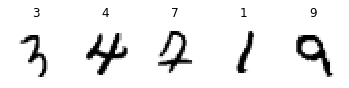

In [121]:
plt.figure(figsize=(6,3))
mnist_train = mnist_train.repeat(5).batch(32).prefetch(1)

for item in mnist_train:
    images = item["image"]
    labels = item["label"]
    for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image, cmap="binary")
        plt.title(label)
        plt.axis("off")
    break # just showing part of the first batch

In [122]:
datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]
mnist_train = mnist_train.repeat(5).batch(32)

In [123]:
mnist_train.element_spec

{'image': TensorSpec(shape=(None, 28, 28, 1), dtype=tf.uint8, name=None),
 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}

In [124]:
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)
for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 28, 28, 1)
[3 4 7 1 9 0 8 8 9 7 2 1 6 6 9 7 4 3 4 0 8 7 6 7 6 5 7 1 8 0 0 0]


In [125]:
datasets = tfds.load(name="mnist", batch_size=32, as_supervised=True)

mnist_train = datasets["train"].repeat().prefetch(1)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5)

Train for 1875 steps
Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 31.9776 - accuracy: 0.8425
Epoch 2/5
1875/1875 [==============================] - 5s 2ms/step - loss: 25.7490 - accuracy: 0.8689
Epoch 3/5
1875/1875 [==============================] - 5s 2ms/step - loss: 24.6417 - accuracy: 0.8744
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 24.2349 - accuracy: 0.8765
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 24.1660 - accuracy: 0.8773


In [126]:
model.evaluate(datasets['test'])

313/313 [==============================] - 1s 4ms/step - loss: 24.1369 - accuracy: 0.8891


[24.136858904299835, 0.8891]

# TensorFlow Hub

In [127]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                           output_shape=[50], input_shape=[], dtype=tf.string)

model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense_4 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 833
Non-trainable params: 48,190,600
_________________________________________________________________


In [128]:
sentences = tf.constant(["It was a great movie", "The actors were amazing"])
embeddings = hub_layer(sentences)

In [129]:
embeddings

<tf.Tensor: id=380505, shape=(2, 50), dtype=float32, numpy=
array([[ 7.45939985e-02,  2.76720114e-02,  9.38646123e-02,
         1.25124469e-01,  5.40293928e-04, -1.09435350e-01,
         1.34755149e-01, -9.57818255e-02, -1.85177118e-01,
        -1.69703495e-02,  1.75612606e-02, -9.06603858e-02,
         1.12110220e-01,  1.04646273e-01,  3.87700424e-02,
        -7.71859884e-02, -3.12189370e-01,  6.99466765e-02,
        -4.88970093e-02, -2.99049795e-01,  1.31183028e-01,
        -2.12630898e-01,  6.96169436e-02,  1.63592950e-01,
         1.05169769e-02,  7.79720694e-02, -2.55230188e-01,
        -1.80790052e-01,  2.93739915e-01,  1.62875261e-02,
        -2.80566931e-01,  1.60284728e-01,  9.87277832e-03,
         8.44555616e-04,  8.39456245e-02,  3.24002892e-01,
         1.53253034e-01, -3.01048346e-02,  8.94618109e-02,
        -2.39153411e-02, -1.50188789e-01, -1.81733668e-02,
        -1.20483577e-01,  1.32937476e-01, -3.35325629e-01,
        -1.46504581e-01, -1.25251599e-02, -1.64428815e-